In [1]:
#Import Libraries
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
import matplotlib.pyplot as plt
from collections import Counter
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint
import os
import cv2
import numpy as np
from collections import deque
from tensorflow.keras.models import load_model
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [2]:
train_dir = 'Facial recognition/train'
test_dir = 'Facial recognition/test'

os.makedirs('models', exist_ok=True)

# Model save path
model_path = 'models/emotion_model.keras'

In [3]:
# Image data generators for loading and augmenting images
train_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_data = train_datagen.flow_from_directory(
    train_dir,
    target_size=(48, 48),
    color_mode='grayscale',
    class_mode='categorical',
    batch_size=64
)

Found 28709 images belonging to 7 classes.


In [4]:
test_data = test_datagen.flow_from_directory(
    test_dir,
    target_size=(48, 48),
    color_mode='grayscale',
    class_mode='categorical',
    batch_size=64
)

Found 7178 images belonging to 7 classes.


### **Train CNN Model**

In [5]:
# Build CNN model
model = Sequential([
    Conv2D(32, (3,3), activation='relu', input_shape=(48,48,1)),
    MaxPooling2D(2,2),
    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D(2,2),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(7, activation='softmax')
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Add a checkpoint callback to save the best model
checkpoint = ModelCheckpoint(
    model_path,
    monitor='val_accuracy',
    save_best_only=True,
    verbose=1
)

# Train and save best model automatically
history = model.fit(
    train_data,
    validation_data=test_data,
    epochs=15,
    callbacks=[checkpoint]
)

print(f"✅ Training complete! Best model saved at: {model_path}")

Epoch 1/15


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


447/449 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.2695 - loss: 1.7823
Epoch 1: val_accuracy improved from None to 0.41042, saving model to models/emotion_model.keras
449/449 ━━━━━━━━━━━━━━━━━━━━ 12s 25ms/step - accuracy: 0.3173 - loss: 1.7066 - val_accuracy: 0.4104 - val_loss: 1.5395
Epoch 2/15
448/449 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.3998 - loss: 1.5549
Epoch 2: val_accuracy improved from 0.41042 to 0.44330, saving model to models/emotion_model.keras
449/449 ━━━━━━━━━━━━━━━━━━━━ 12s 26ms/step - accuracy: 0.4060 - loss: 1.5310 - val_accuracy: 0.4433 - val_loss: 1.4414
Epoch 3/15
448/449 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.4368 - loss: 1.4564
Epoch 3: val_accuracy improved from 0.44330 to 0.46851, saving model to models/emotion_model.keras
449/449 ━━━━━━━━━━━━━━━━━━━━ 12s 27ms/step - accuracy: 0.4440 - loss: 1.4454 - val_accuracy: 0.4685 - val_loss: 1.3819
Epoch 4/15
449/449 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.4634 - loss: 1.3900
Epoch 4: val

### **Plot training and validation metrics**

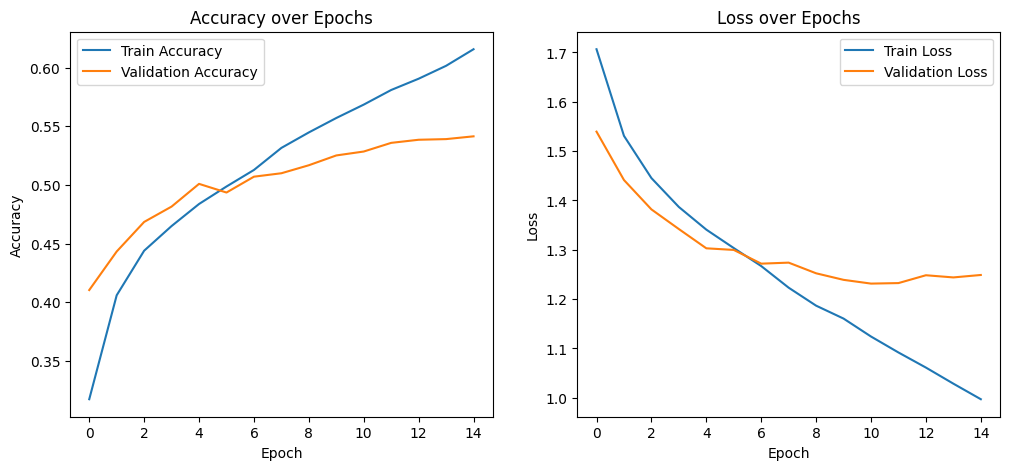

In [6]:
plt.figure(figsize=(12,5))

# Accuracy plot
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Loss plot
plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()

#### **Real-time Emotion Detection**

In [7]:
# Load trained model
model = load_model('models/emotion_model.keras')
emotions = ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']

# Face detector
face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')
cap = cv2.VideoCapture(0)

# Keep last N predictions for smoothing
N = 6
predictions_queue = deque(maxlen=N)  # sliding window

print("🎥 Press 'q' to quit")

while True:
    ret, frame = cap.read()
    if not ret:
        break

    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray, 1.3, 5)

    for (x, y, w, h) in faces:
        roi = gray[y:y+h, x:x+w]
        roi = cv2.resize(roi, (48,48))
        roi = roi.astype('float') / 255.0
        roi = np.expand_dims(roi, axis=(0, -1))

        preds = model.predict(roi)
        emotion_label = emotions[np.argmax(preds)]

        # Add to sliding window
        predictions_queue.append(emotion_label)

        # Get the most frequent emotion in the last N frames
        most_common_emotion = Counter(predictions_queue).most_common(1)[0][0]

        # Draw rectangle and stable label
        cv2.rectangle(frame, (x, y), (x+w, y+h), (0,255,0), 2)
        cv2.putText(frame, most_common_emotion, (x, y-10), cv2.FONT_HERSHEY_SIMPLEX, 1, (255,255,255), 2)

    cv2.imshow('Facial Expression Recognition', frame)

    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

cap.release()
cv2.destroyAllWindows()


2025-11-18 20:41:42.809 Python[12201:3001044] WARNING: AVCaptureDeviceTypeExternal is deprecated for Continuity Cameras. Please use AVCaptureDeviceTypeContinuityCamera and add NSCameraUseContinuityCameraDeviceType to your Info.plist.


🎥 Press 'q' to quit
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10

#### **Emotions that are misclassified**

For e.g. If “fear” is confused with “surprise”

113/113 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step


<Figure size 800x600 with 0 Axes>

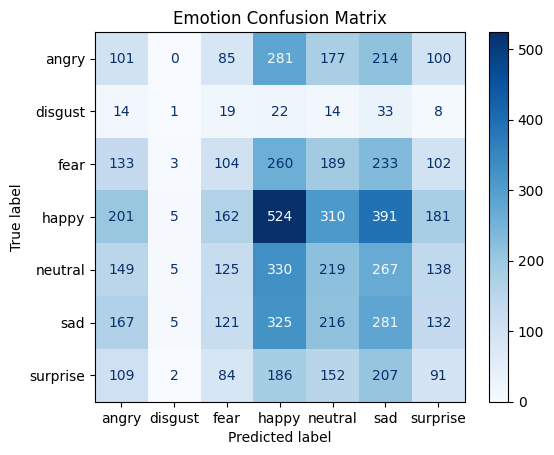

In [8]:
# Get predictions
y_true = test_data.classes
y_pred = model.predict(test_data)
y_pred = np.argmax(y_pred, axis=1)

# Class labels
labels = list(test_data.class_indices.keys())

# Confusion matrix
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(8,6))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot(cmap='Blues', values_format='d')
plt.title("Emotion Confusion Matrix")
plt.show()


#### **Sample prediction grid**

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


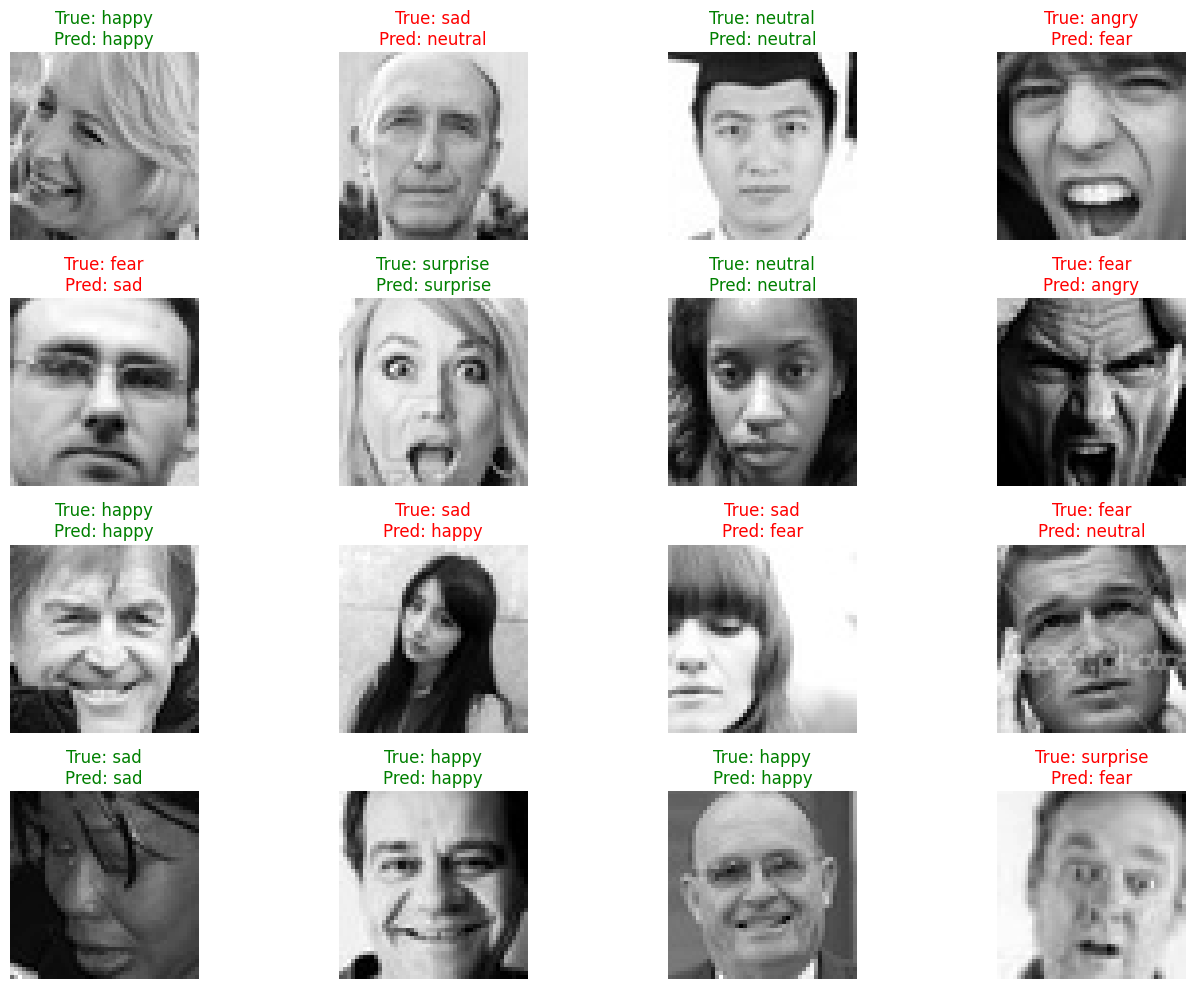

In [9]:
x_batch, y_batch = next(test_data)
preds = model.predict(x_batch)

plt.figure(figsize=(14,10))
for i in range(16):
    plt.subplot(4,4,i+1)
    img = x_batch[i].reshape(48,48)
    true_label = np.argmax(y_batch[i])
    pred_label = np.argmax(preds[i])

    color = "green" if true_label == pred_label else "red"
    plt.imshow(img, cmap='gray')
    plt.title(f"True: {emotions[true_label]}\nPred: {emotions[pred_label]}", color=color)
    plt.axis("off")

plt.tight_layout()
plt.show()

#### **Emotion probability bar chart**

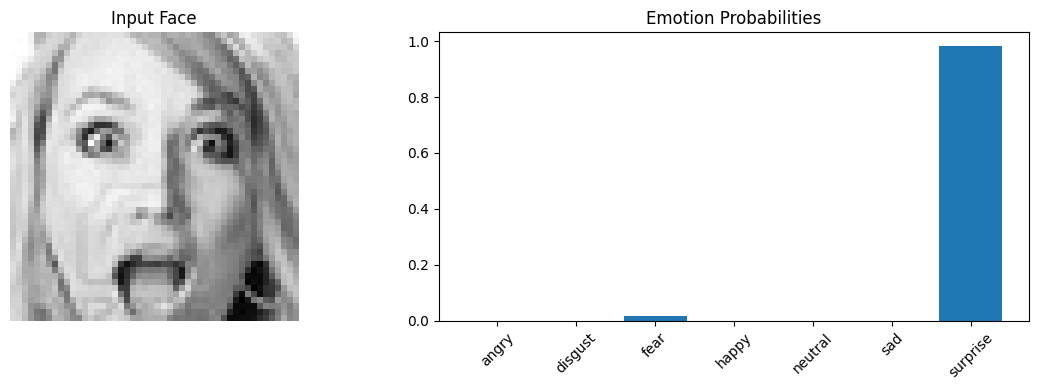

In [10]:
i = 5  # pick test sample index

plt.figure(figsize=(12,4))

# Image
plt.subplot(1,2,1)
plt.imshow(x_batch[i].reshape(48,48), cmap='gray')
plt.title("Input Face")
plt.axis("off")

# Probabilities
plt.subplot(1,2,2)
plt.bar(emotions, preds[i])
plt.title("Emotion Probabilities")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()